In [1]:
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%capture
!pip install backtesting

In [3]:
%matplotlib inline
import backtesting as bt
from backtesting import Backtest, Strategy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# set cpu or gpu enabled device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type

/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


In [6]:
class cfg_LSTM1d:  
  # Configuration parameters for the LSTM model trained on 1D data
  # Includes settings for data split, sequence length, learning rate, number of epochs, 
  # file paths, feature and target column names, LSTM settings (input size, hidden size, number of layers), and model save path
  
  split_fraction = 0.85
  time_steps = 5 # number of predictor timesteps
  horizon = 1 # number of timesteps to be predicted
  sequence_length = time_steps + horizon # determine sequence length
  learning_rate=0.01
  num_epochs=2000
  path = '/content/drive/MyDrive/stock predict/technical/1D_technical.csv'
  features = ['close']
  target = 'close'
  input_size = len(features)
  hidden_size = 50
  output_size = 1
  numlayers = 2
  save_path = '/content/drive/MyDrive/stock predict/pred_close1d.pt'
  cols = ['open', 'high', 'low', 'close', 'rsi']

class cfg_30m:  
  split_fraction = 1
  time_steps = 5 # number of predictor timesteps
  horizon = 1 # number of timesteps to be predicted
  sequence_length = time_steps + horizon # determine sequence length
  learning_rate=0.01
  num_epochs=5000
  path = '/content/drive/MyDrive/stock predict/30_min.csv'
  features = ['close']
  target = 'close'
  input_size = len(features)
  hidden_size = 50
  output_size = 1
  numlayers = 2
  save_path = '/content/drive/MyDrive/stock predict/pred_30m.pt'

class cfg_stack:
  learning_rate=0.001
  num_epochs=2000
  save_path = '/content/drive/MyDrive/stock predict/pred_stacked.pt'
  val_length = 0

def load_data(path, features, type):
  data_raw = pd.read_csv(path)
  data_raw.columns = data_raw.columns.str.replace(' ', '')
  data_raw['time'] = pd.to_datetime(data_raw['time'])
  data_raw['time'] = data_raw['time'].dt.date
  if type == '1d':
    data_raw.set_index('time', inplace=True)
  df = data_raw[features].copy()
  return df, data_raw

def splitrow(df, split_fraction):
  return int(df.shape[0] * split_fraction)

def trainvalidsplit(df, split_row):
  train = df.iloc[:split_row].copy()
  valid = df.iloc[split_row:].copy()
  return train, valid

def create_sequences(df, seq_length = cfg_LSTM1d.sequence_length):
    df = df.values  # Convert DataFrame to numpy array
    
    n = df.shape[0]
    xs = np.zeros((n - seq_length, seq_length, df.shape[1]))
    ys = np.zeros((n - seq_length, 1))
    
    for i in range(n - seq_length):
        xs[i] = df[i:(i+seq_length)]
        ys[i] = df[i+seq_length, -1]  # predict the 'return' column one step ahead
    
    # Convert to PyTorch tensors
    X = torch.from_numpy(xs)
    y = torch.from_numpy(ys)
    
    return X, y

class LSTM1d(nn.Module):
    def __init__(self, input_size = cfg_LSTM1d.input_size, hidden_size = cfg_LSTM1d.hidden_size, 
                 num_layers = cfg_LSTM1d.numlayers, output_size=cfg_LSTM1d.output_size):

      super(LSTM1d, self).__init__()
      
      self.hidden_size = hidden_size
      self.num_layers = num_layers     
      self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout = 0.2)    
      self.fc1 = nn.Linear(hidden_size, output_size)
      #self.fc2 = nn.Linear(10, output_size)  # Add a second layer
      self.tanh = nn.Tanh()

    def forward(self, x):
      h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) 
      c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) 
      h0.requires_grad = True
      c0.requires_grad = True
      out, _ = self.lstm(x, (h0.detach(), c0.detach()))
      out = self.tanh(self.fc1(out[:, -1, :]))  # apply tanh activation function to the output of the first linear layer
      #out = self.fc2(out)  # pass through the second linear layer
      return out


class Stacking(nn.Module):
    def __init__(self):
        super(Stacking, self).__init__()
        self.fc1 = nn.Linear(2, 2)
        self.fc2 = nn.Linear(2, 1)

        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.fc2(x)
        return x


def train_fn(model, train, train_target, 
          learning_rate, num_epochs, save_path, type, valid = None, 
          valid_target = None):

  criterion = torch.nn.MSELoss(reduction='mean')
  optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

  train = train.float().to(device)  # Convert to float
  train_target = train_target.float().to(device)  # Convert to float

  if type in ['1d']:
    valid = valid.float().to(device)  # Convert to float
    valid_target = valid_target.float().to(device)  # Convert to float

    best_loss = float('inf')

  for epoch in range(num_epochs):

    model.train()
    y_train_pred = model(train)

    print(y_train_pred.shape)
    train_loss = criterion(y_train_pred, train_target)
    optimiser.zero_grad()
    train_loss.backward()
    optimiser.step()

    if type in ['1d']:
      model.eval()
      outputs = model(valid)
      val_loss = criterion(outputs, valid_target)

    print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss.item():.4f}, ')
    
    if type in ['1d']:
      print(f'Validation Loss: {val_loss.item():.4f}')
    
      if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model, save_path)
    else: torch.save(model, save_path)


def createpreds(model_path, t_scaler, sequences, device = device ):
  model = torch.load(model_path)
  model = model.to(device)
  model.eval()
  sequences = sequences.float().to(device) # Convert to float

  preds = model(sequences)
  preds = pd.DataFrame(t_scaler.inverse_transform(preds.detach().cpu().numpy()))
  return preds

def create_fulldf(data_raw, preds , cols, startrow):
  bt_df = data_raw[cols].copy()
  bt_df = bt_df[startrow:]
  bt_df['predictions_1d'] = preds.values
  return bt_df

def plotpred(df, actual, pred, length):
  plt.figure(figsize=(20,8))
  plt.title('Price vs Prediction')
  plt.plot(df[len(df)-length:][actual], color = 'blue', label = 'Actual Close Price')
  plt.plot(df[len(df)-length:][pred], color = 'red', label = 'Predicted Close Price')
  plt.legend()
  plt.show()

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
Epoch 334/2000, Train Loss: 0.0007, 
Validation Loss: 0.0019
torch.Size([8165, 1])
Epoch 335/2000, Train Loss: 0.0007, 
Validation Loss: 0.0019
torch.Size([8165, 1])
Epoch 336/2000, Train Loss: 0.0007, 
Validation Loss: 0.0019
torch.Size([8165, 1])
Epoch 337/2000, Train Loss: 0.0007, 
Validation Loss: 0.0019
torch.Size([8165, 1])
Epoch 338/2000, Train Loss: 0.0007, 
Validation Loss: 0.0020
torch.Size([8165, 1])
Epoch 339/2000, Train Loss: 0.0007, 
Validation Loss: 0.0020
torch.Size([8165, 1])
Epoch 340/2000, Train Loss: 0.0008, 
Validation Loss: 0.0022
torch.Size([8165, 1])
Epoch 341/2000, Train Loss: 0.0009, 
Validation Loss: 0.0023
torch.Size([8165, 1])
Epoch 342/2000, Train Loss: 0.0010, 
Validation Loss: 0.0026
torch.Size([8165, 1])
Epoch 343/2000, Train Loss: 0.0012, 
Validation Loss: 0.0024
torch.Size([8165, 1])
Epoch 344/2000, Train Loss: 0.0011, 
Validation Loss: 0.0021
torch.Size([8165, 1])
Epoch 345/2000, Trai

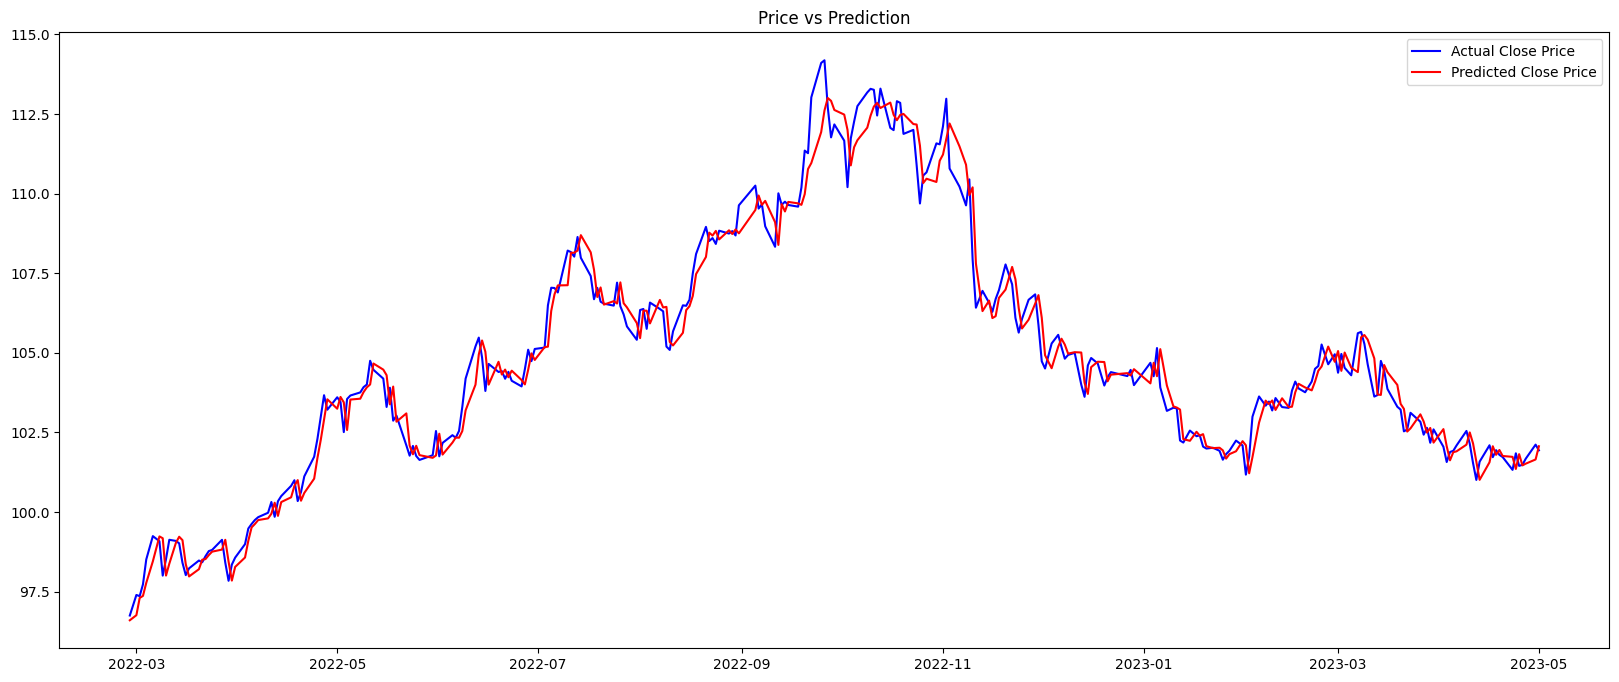

torch.Size([27820, 1])
Epoch 1/5000, Train Loss: 0.3334, 
torch.Size([27820, 1])
Epoch 2/5000, Train Loss: 0.2531, 
torch.Size([27820, 1])
Epoch 3/5000, Train Loss: 0.2192, 
torch.Size([27820, 1])
Epoch 4/5000, Train Loss: 0.1864, 
torch.Size([27820, 1])
Epoch 5/5000, Train Loss: 0.1145, 
torch.Size([27820, 1])
Epoch 6/5000, Train Loss: 0.0553, 
torch.Size([27820, 1])
Epoch 7/5000, Train Loss: 0.0183, 
torch.Size([27820, 1])
Epoch 8/5000, Train Loss: 0.0276, 
torch.Size([27820, 1])
Epoch 9/5000, Train Loss: 0.0524, 
torch.Size([27820, 1])
Epoch 10/5000, Train Loss: 0.0603, 
torch.Size([27820, 1])
Epoch 11/5000, Train Loss: 0.0535, 
torch.Size([27820, 1])
Epoch 12/5000, Train Loss: 0.0421, 
torch.Size([27820, 1])
Epoch 13/5000, Train Loss: 0.0325, 
torch.Size([27820, 1])
Epoch 14/5000, Train Loss: 0.0265, 
torch.Size([27820, 1])
Epoch 15/5000, Train Loss: 0.0248, 
torch.Size([27820, 1])
Epoch 16/5000, Train Loss: 0.0252, 
torch.Size([27820, 1])
Epoch 17/5000, Train Loss: 0.0264, 
torch.

KeyboardInterrupt: ignored

In [5]:
t_scaler1d = MinMaxScaler(feature_range=(-1, 1))
t_scaler30m = MinMaxScaler(feature_range=(-1, 1))
t_scaler_comb = MinMaxScaler(feature_range=(-1, 1))
f_scaler1d = MinMaxScaler(feature_range=(-1, 1))
f_scalercomb = MinMaxScaler(feature_range=(-1, 1))

#LSTM 1d model

df_1d, data_1draw = load_data(path = cfg_LSTM1d.path, features = cfg_LSTM1d.features, type = '1d')
split_row1d = splitrow(df_1d, split_fraction = cfg_LSTM1d.split_fraction)
train_1d, valid_1d = trainvalidsplit(df_1d, split_row = split_row1d)

train1d_scaled = train_1d.copy()
valid1d_scaled = valid_1d.copy()
train1d_scaled[cfg_LSTM1d.target] = t_scaler1d.fit_transform(train_1d[cfg_LSTM1d.target].values.reshape(-1,1))
valid1d_scaled[cfg_LSTM1d.target] = t_scaler1d.fit_transform(valid_1d[cfg_LSTM1d.target].values.reshape(-1,1))

train_sequences1d, train_target1d = create_sequences(df = train1d_scaled, seq_length = cfg_LSTM1d.sequence_length)
valid_sequences1d, valid_target1d = create_sequences(df = valid1d_scaled, seq_length = cfg_LSTM1d.sequence_length)

model1d = LSTM1d()
model1d = model1d.to(device)

train_fn(model = model1d, train = train_sequences1d, train_target = train_target1d, valid = valid_sequences1d, 
         valid_target = valid_target1d, learning_rate = cfg_LSTM1d.learning_rate, 
         num_epochs = cfg_LSTM1d.num_epochs, save_path = cfg_LSTM1d.save_path, type = '1d')

pred1d = createpreds(model_path = cfg_LSTM1d.save_path, t_scaler = t_scaler1d, 
                     sequences = valid_sequences1d, device = device )

bt_df = create_fulldf(data_raw = data_1draw, preds = pred1d, cols = cfg_LSTM1d.cols, 
                      startrow = split_row1d + cfg_LSTM1d.sequence_length)

plotpred(df = bt_df, actual = 'close', pred = 'predictions_1d', length = 300)


#LSTM 30m model

df_30m, data_30mraw = load_data(path = cfg_30m.path, features = cfg_30m.features, type = '30m')

split_row30m = splitrow(df_30m, split_fraction =cfg_30m.split_fraction)
train_30m, valid_30m = trainvalidsplit(df_30m, split_row = split_row30m)

train30_scaled = train_30m.copy()
valid30_scaled = valid_30m.copy()

train30_scaled[cfg_30m.target] = t_scaler30m.fit_transform(train30_scaled[cfg_30m.target].values.reshape(-1,1))
train_sequences30m, train_target30m = create_sequences(df = train30_scaled, seq_length = cfg_30m.sequence_length)

if not valid30_scaled.empty:
  valid30_scaled[cfg_30m.target] = t_scaler30m.fit_transform(valid30_scaled[cfg_30m.target].values.reshape(-1,1))
  valid_sequences30m, valid_target30m = create_sequences(df = valid30_scaled, seq_length = cfg_30m.sequence_length)


model30m = LSTM1d()
model30m = model30m.to(device)

train_fn(model = model30m, train = train_sequences30m, train_target = train_target30m,  
          learning_rate = cfg_30m.learning_rate, 
         num_epochs = cfg_30m.num_epochs, save_path = cfg_30m.save_path, type = '30m')

pred30m = createpreds(model_path = cfg_30m.save_path, t_scaler = t_scaler30m, 
                     sequences = train_sequences30m, device = device )

df_30m = data_30mraw[cfg_30m.sequence_length:].copy()
df_30m['pred_30'] = pred30m.values

plotpred(df = df_30m, actual = 'close', pred = 'pred_30', length = 300)

df_30m = df_30m[df_30m['time'] != df_30m['time'].shift()]

df_comb = bt_df.merge(df_30m[['time', 'pred_30']], on='time', how = 'inner')

#######stacking


# Split data into training and validation sets
train_comb = df_comb[['predictions_1d', 'pred_30']].copy()
#val_comb = df_comb[['predictions_1d', 'pred_30']][-cfg_stack.val_length:]

traincomb_target = df_comb[['close']].copy()
#valcomb_target = df_comb[['close']][-100:]

train_comb_scaled = f_scalercomb.fit_transform(train_comb)
#val_comb_scaled = f_scalercomb.transform(val_comb)

traincomb_target_scaled = t_scaler_comb.fit_transform(traincomb_target.values.reshape(-1,1))
#valcomb_target_scaled = t_scaler_comb.transform(valcomb_target.values.reshape(-1,1))

# Convert features and target to tensors
train_features_tensor = torch.tensor(train_comb_scaled, dtype=torch.float32)
train_target_tensor = torch.tensor(traincomb_target_scaled, dtype=torch.float32).view(-1, 1)

#val_features_tensor = torch.tensor(val_comb_scaled, dtype=torch.float32)
#val_target_tensor = torch.tensor(valcomb_target_scaled, dtype=torch.float32).view(-1, 1)


comb_model = Stacking()
comb_model = comb_model.to(device)

train_fn(model = comb_model, train = train_features_tensor, train_target = train_target_tensor, 
         #valid = val_features_tensor, valid_target = val_target_tensor, 
          learning_rate = cfg_stack.learning_rate, 
         num_epochs = cfg_stack.num_epochs, save_path = cfg_stack.save_path, type = 'stack')

predfinal = createpreds(model_path = cfg_stack.save_path, t_scaler = t_scaler_comb, 
                     sequences = train_features_tensor, device = device )

###Backtesting

backtest = df_comb[-300:].copy()
backtest['predictions_final'] = predfinal[-300:].values
backtest = backtest.reset_index(drop=True)

threshold = 0
backtest['predictions_final'] = backtest['predictions_final'].shift(-1)
backtest['Signal'] = 0
backtest.loc[backtest['predictions_final']>backtest['close']+threshold, 'Signal' ] =1
backtest.loc[backtest['predictions_final']+threshold<backtest['close'], 'Signal' ] =-1
backtest = backtest.rename(columns=lambda x: x.capitalize())
backtest = backtest[:-1].copy()

backtest = backtest.set_index('Time')


class SignalStrategy(Strategy):
    def init(self):
        self.signal = self.I(lambda x: x, self.data['Signal'])
        self.rsi = self.I(lambda x: x, self.data['Rsi'])

    def next(self):
        if self.signal[-1] == 1 and self.rsi[-1] >=50:
            if not self.position or self.position.is_short:
                if self.position:
                    self.position.close()
                self.buy()

        elif self.signal[-1] == -1 and self.rsi[-1] <50:
            if not self.position or self.position.is_long:
                if self.position:
                    self.position.close()
                self.sell()


# Create a backtest and run it
btest = Backtest(backtest, SignalStrategy, cash=100000)
stats = btest.run()

print(stats)

btest.plot(superimpose=False)


In [ ]:
stats = bt.run()

print(stats)

In [ ]:
from joblib import dump

def save_scalers(t_scaler1d, t_scaler30m, t_scaler_comb, f_scaler1d, f_scalercomb):
    """
    Saves the scalers to the disk

    Parameters
    ----------
    t_scaler1d : sklearn scaler object
        Time scaler for 1 day
    t_scaler30m : sklearn scaler object
        Time scaler for 30 minutes
    t_scaler_comb : sklearn scaler object
        Combined time scaler
    f_scaler1d : sklearn scaler object
        Feature scaler for 1 day
    f_scalercomb : sklearn scaler object
        Combined feature scaler

    Returns
    -------
    None
    """

    dump(t_scaler1d, '/content/drive/MyDrive/stock predict/t_scaler1d.joblib')
    dump(t_scaler30m, '/content/drive/MyDrive/stock predict/t_scaler30m.joblib')
    dump(t_scaler_comb, '/content/drive/MyDrive/stock predict/t_scaler_comb.joblib')
    dump(f_scaler1d, '/content/drive/MyDrive/stock predict/f_scaler1d.joblib')
    dump(f_scalercomb, '/content/drive/MyDrive/stock predict/f_scalercomb.joblib')
save_scalers(t_scaler1d, t_scaler30m, t_scaler_comb, f_scaler1d, f_scalercomb)


In [ ]:
from joblib import load

t_scaler1d = load('/content/drive/MyDrive/stock predict/t_scaler1d.joblib')
t_scaler30m = load('/content/drive/MyDrive/stock predict/t_scaler30m.joblib')
t_scaler_comb = load('/content/drive/MyDrive/stock predict/t_scaler_comb.joblib')
f_scaler1d = load('/content/drive/MyDrive/stock predict/f_scaler1d.joblib')
f_scalercomb = load('/content/drive/MyDrive/stock predict/f_scalercomb.joblib')

In [ ]:
def load_data(path, features='close'):
  data_raw = pd.read_csv(path)
  data_raw.columns = data_raw.columns.str.replace(' ', '')
  data_raw['time'] = pd.to_datetime(data_raw['time'])
  data_raw['time'] = data_raw['time'].dt.date
  data_raw = data_raw[-6:].copy()
  df = data_raw[[features]].copy()
  return df, data_raw


In [ ]:
df1d, df1d_raw = load_data('/content/drive/MyDrive/stock predict/technical/1D_technical.csv', features='close')
df30, _ = load_data('/content/drive/MyDrive/stock predict/30_min.csv', features='close')

In [ ]:
df1d['close'] = t_scaler1d.transform(df1d['close'].values.reshape(-1,1))
df30['close'] = t_scaler30m.transform(df30['close'].values.reshape(-1,1))

In [ ]:
model1d = torch.load('/content/drive/MyDrive/stock predict/pred_close1d.pt')
model30 = torch.load('/content/drive/MyDrive/stock predict/pred_30m.pt')
modelstack = torch.load('/content/drive/MyDrive/stock predict/pred_stacked.pt')

In [ ]:
import torch

def df_to_tensor(df):
    """
    Convert the first 6 rows of a DataFrame into a tensor suitable for LSTM input.

    Args:
    df (pd.DataFrame): Input DataFrame

    Returns:
    torch.Tensor: A tensor of shape (1, sequence_length, number_of_features)
    """
    # Select the first 6 rows
    df_values = df[:6].values  

    # Convert the 2D array into a 3D array of shape (1, sequence_length, number_of_features)
    # In your case, sequence_length is 6
    df_values = df_values.reshape(1, 6, -1)

    # Convert the numpy array to a torch tensor
    df_tensor = torch.tensor(df_values, dtype=torch.float32)

    # Ensure the tensor is on the correct device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    df_tensor = df_tensor.to(device)

    return df_tensor


In [ ]:
seq1d = df_to_tensor(df1d)
seq30 = df_to_tensor(df30)

In [ ]:
pred1d = model1d(seq1d)
pred30 = model30(seq30)

In [ ]:
pred_combined = torch.cat((pred1d, pred30), dim=1)

In [ ]:
prediction = modelstack(pred_combined)

In [ ]:
prediction = t_scaler1d.inverse_transform(prediction.detach().cpu().numpy())[0][0]

In [ ]:
def hlcl(df):
    df_last_three = df.tail(3)
    
    # Compute average distances
    avg_high_close = abs(df_last_three['high'] - df_last_three['close']).mean()
    avg_low_close = abs(df_last_three['low'] - df_last_three['close']).mean()

    return avg_high_close, avg_low_close

In [ ]:
import torch
import pandas as pd

def load_model(model_path):
    model = torch.load(model_path)
    return model

def load_dataframe(df_path):
    df = pd.read_csv(df_path)
    return df

def main():

    # Hardcoded model paths
    pred1d_path = 'path_to_pred1d'
    pred30m_path = 'path_to_pred30m'
    predstacked_path = 'path_to_predstacked'

    # Load models
    model1d = load_model(pred1d_path)
    model30m = load_model(pred30m_path)
    modelStacked = load_model(predstacked_path)

    # Create the parser
    parser = argparse.ArgumentParser(description="Load two dataframes based on given paths.")

    # Add the arguments
    parser.add_argument("DF1", metavar="df1", type=str, help="The path to the first dataframe.")
    parser.add_argument("DF2", metavar="df2", type=str, help="The path to the second dataframe.")

    # Execute the parse_args() method
    args = parser.parse_args()

    # Load dataframes
    df1 = load_dataframe(args.DF1)
    df2 = load_dataframe(args.DF2)

    print(f"Models and dataframes loaded successfully!")

if __name__ == '__main__':
    main()
